In [1]:
"""
AR(1) model with missing observations
"""
import numpy as np
import pandas as pd
import linkalman
import scipy
from linkalman.models import BaseConstantModel as BCM
from linkalman.core.utils import simulated_data, ft, df_to_list, list_to_df, \
        gen_PSD, get_ergodic, create_col, clean_matrix
from linkalman.core import Filter
import nlopt
import matplotlib.pyplot as plt
%matplotlib inline 



In [2]:
def my_f(theta):
    """
    AR(1) model. In general, MLE is biased, so the focus should be 
    more on prediction fit, less on parameter estimation. The 
    formula here for Ar(1) is:
    y_t = c + Fy_{t-1} + epsilon_{t-1}
    """
    # Define theta
    phi_1 = 1 / (np.exp(theta[0])+1)
    sigma = np.exp(theta[1]) 
    sigma_R = np.exp(theta[2])
    # Generate F
    F = np.array([[phi_1]])
    # Generate Q
    Q = np.array([[sigma]]) 
    # Generate R
    R = np.array([[sigma_R]])
    # Generate H
    H = np.array([[1]])
    # Generate B
    B = np.array([[theta[3]]])
    # Collect system matrices
    M = {'F': F, 'Q': Q, 'H': H, 'R': R, 'B': B}

    return M


In [3]:
def my_solver(param, obj_func, **kwargs):
    
    def nlopt_obj(x, grad, **kwargs):
        fval_opt = obj_func(x)
        if kwargs.get('verbose', False):
            print('fval: {}'.format(fval_opt))
        return fval_opt

    opt = nlopt.opt(nlopt.LN_BOBYQA, param.shape[0])
    obj = lambda x, grad: nlopt_obj(x, grad, **kwargs)
    opt.set_max_objective(obj)
    opt.set_xtol_rel(kwargs.get('xtol_rel', opt.get_xtol_rel()))
    opt.set_ftol_rel(kwargs.get('ftol_rel', opt.get_ftol_rel()))
    theta_opt = opt.optimize(param)
    fval_opt = opt.last_optimum_value()
    if kwargs.get('verbose_opt', False):
        print('fval: {}'.format(fval_opt))
        
    return theta_opt, fval_opt

In [4]:
# Initialize the model
x = 1
model = BCM()
model.set_f(my_f, x_0=x * np.ones([1, 1]))

In [5]:
# Generate fake data
theta = np.array([-1, -0.1, -0.2, 1])
T = 300

missing_start = np.floor(T * 0.2).astype(int)
missing_end = np.floor(T * 0.4).astype(int)

# Split train data
cutoff_t = np.floor(T * 0.7).astype(int)

# Generate missing data for forcasting
offset_t = np.floor(T * 0.9).astype(int)
x_col = ['const']
Xt = pd.DataFrame({x_col[0]: x * np.ones(T)})

df, y_col, xi_col = model.simulated_data(input_theta=theta, Xt=Xt, T=T)
df['y_0_vis'] = df.y_0.copy()

# Create missing values
is_missing = (df.index < missing_end) & (df.index >= missing_start)
df.loc[is_missing, ['y_0']] = np.nan

# Create a training set
df_train = df.iloc[0:cutoff_t].copy()
df_test = df.copy()  # Keep the full data for forward prediction

# Create an offset
df_test.loc[df.index >= offset_t, ['y_0']] = np.nan



In [6]:
# Fit data using LLY:
theta_init = np.random.rand(len(theta))
model.set_solver(my_solver, xtol_rel=1e-5) 
model.fit(df_train, theta_init, y_col=y_col, x_col=x_col, method='LLY')
theta_LLY = model.theta_opt

# Make predictions from LLY:
df_LLY = model.predict(df_test, theta=theta_LLY)
df_LLY['kf_ub'] = df_LLY.y_0_filtered + 1.96 * np.sqrt(df_LLY.y_0_fvar)
df_LLY['kf_lb'] = df_LLY.y_0_filtered - 1.96 * np.sqrt(df_LLY.y_0_fvar)

# Make predictions using true theta:
df_true = model.predict(df_test, theta=theta)
df_true['kf_ub'] = df_true.y_0_filtered + 1.96 * np.sqrt(df_true.y_0_fvar)
df_true['kf_lb'] = df_true.y_0_filtered - 1.96 * np.sqrt(df_true.y_0_fvar)



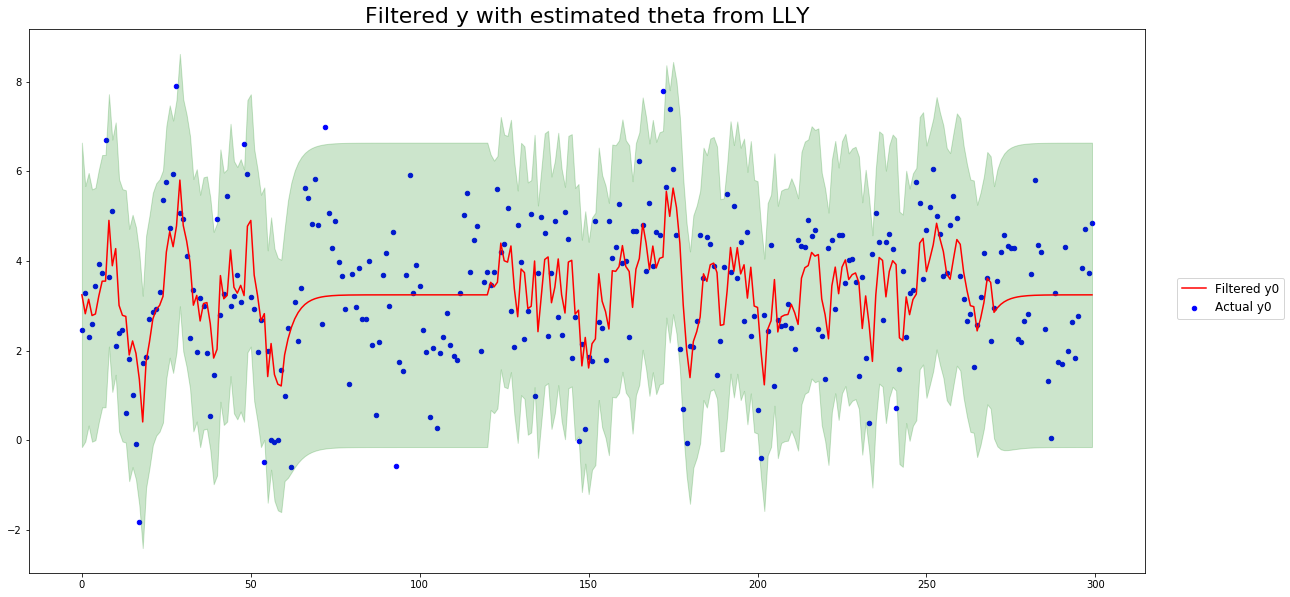

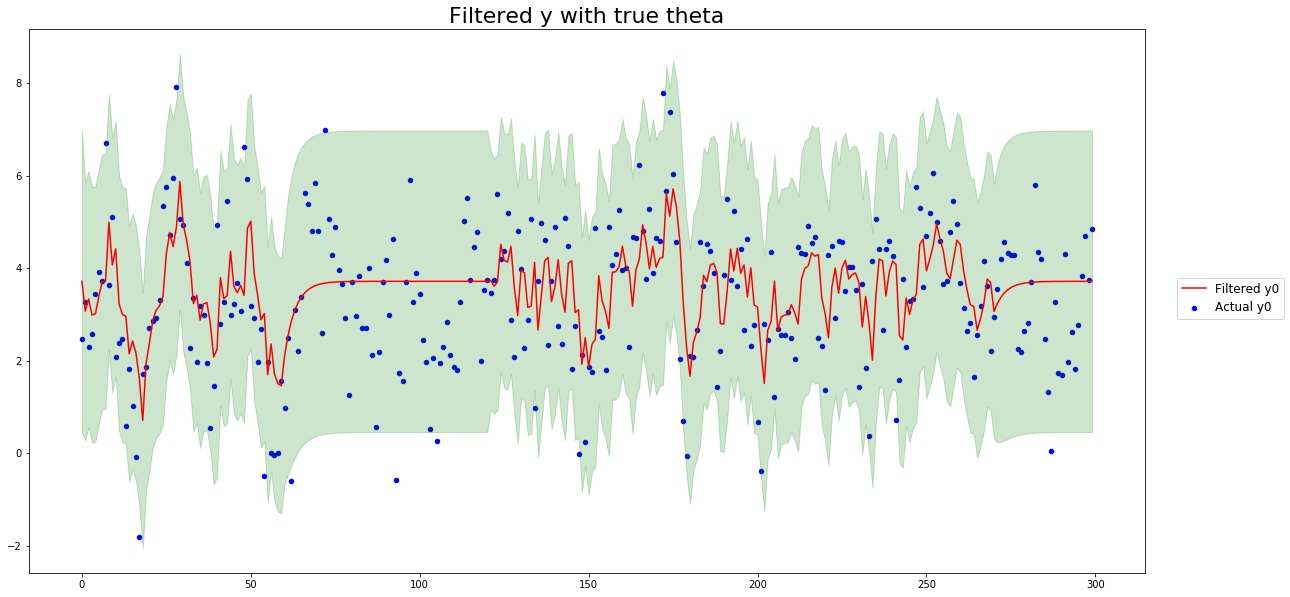

In [7]:
ax = plt.figure(figsize=(20, 10))
plt.plot(df_LLY.index, df_LLY.y_0_filtered, 'r', label='Filtered y0')
plt.scatter(df_LLY.index, df_LLY.y_0_vis, s=20, c='b', marker='o', label='Actual y0')
plt.fill_between(df_LLY.index, df_LLY.kf_ub, df_LLY.kf_lb, color='g', alpha=0.2)
ax.legend(loc='right', fontsize=12)
plt.title('Filtered y with estimated theta from LLY', fontsize=22)
plt.show()

ax = plt.figure(figsize=(20, 10))
plt.plot(df_true.index, df_true.y_0_filtered, 'r', label='Filtered y0')
plt.scatter(df_true.index, df_true.y_0_vis, s=20, c='b', marker='o', label='Actual y0')
plt.fill_between(df_true.index, df_true.kf_ub, df_true.kf_lb, color='g', alpha=0.2)
ax.legend(loc='right', fontsize=12)
plt.title('Filtered y with true theta', fontsize=22)
plt.show()

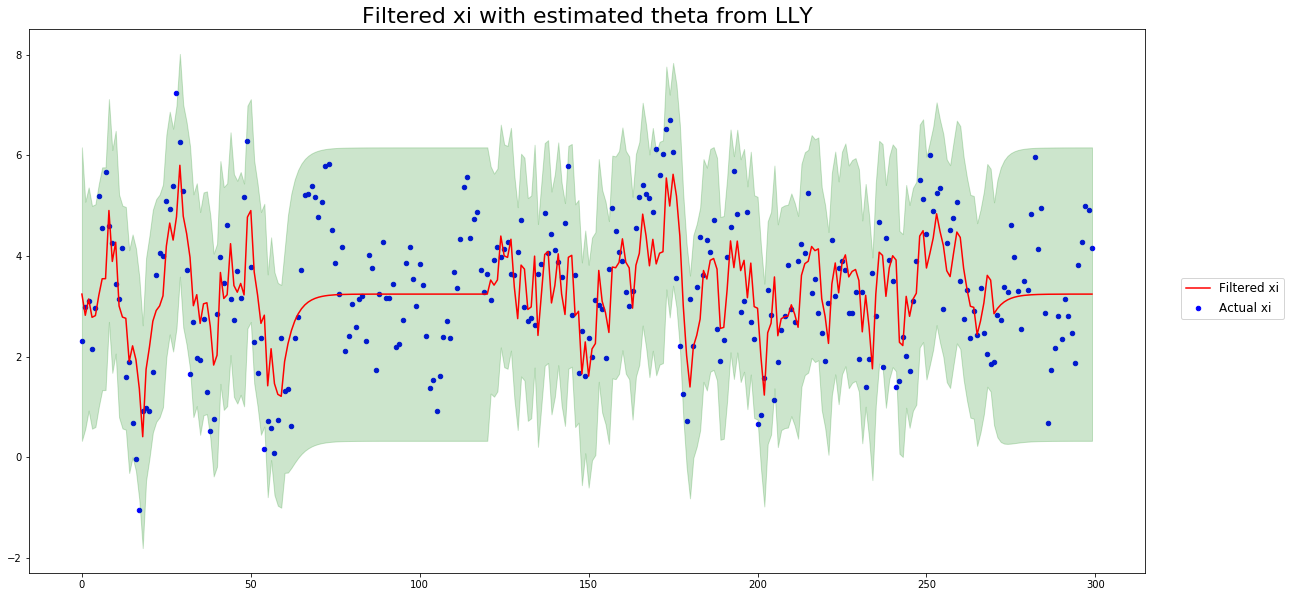

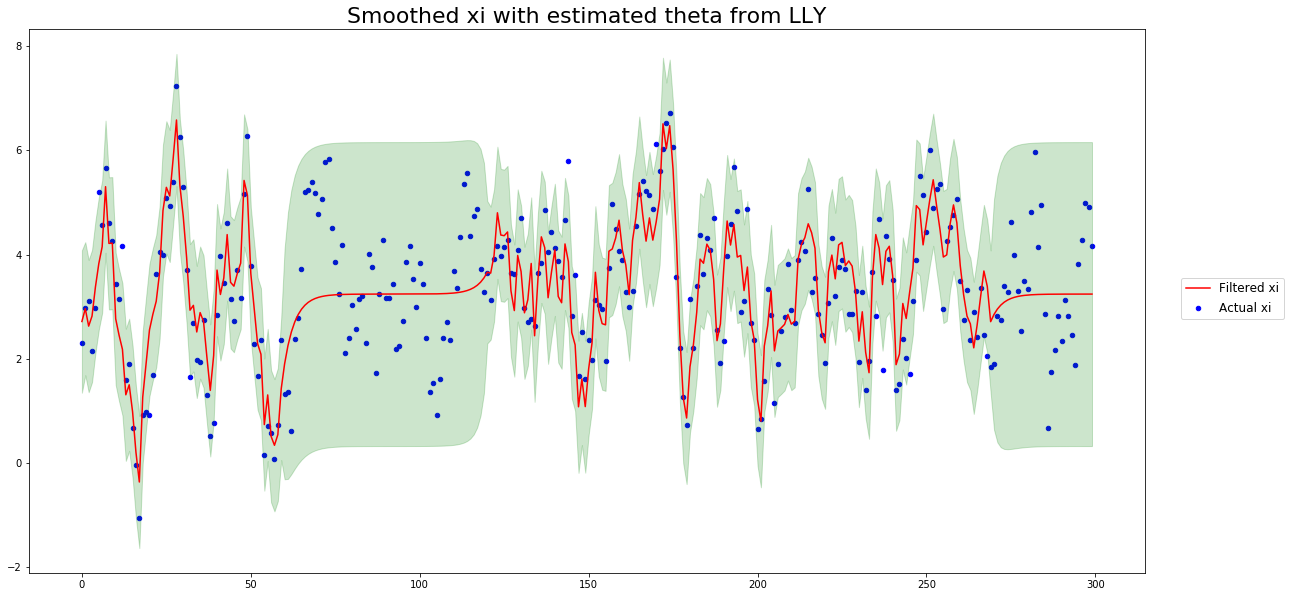

In [8]:
# View filtered states and smoothed states with theta_opt from LLY
df_LLY['xi0_f_ub'] = df_LLY.xi0_filtered + 1.96 * np.sqrt(df_LLY.P0_filtered)
df_LLY['xi0_f_lb'] = df_LLY.xi0_filtered - 1.96 * np.sqrt(df_LLY.P0_filtered)
df_LLY['xi0_s_ub'] = df_LLY.xi0_smoothed + 1.96 * np.sqrt(df_LLY.P0_smoothed)
df_LLY['xi0_s_lb'] = df_LLY.xi0_smoothed - 1.96 * np.sqrt(df_LLY.P0_smoothed)
ax = plt.figure(figsize=(20, 10))
plt.plot(df_LLY.index, df_LLY.xi0_filtered, 'r', label='Filtered xi')
plt.scatter(df_LLY.index, df_LLY.xi_0, s=20, c='b', marker='o', label='Actual xi')
plt.fill_between(df_LLY.index, df_LLY.xi0_f_ub, df_LLY.xi0_f_lb, color='g', alpha=0.2)
ax.legend(loc='right', fontsize=12)
plt.title('Filtered xi with estimated theta from LLY', fontsize=22)
plt.show()


ax = plt.figure(figsize=(20, 10))
plt.plot(df_LLY.index, df_LLY.xi0_smoothed, 'r', label='Filtered xi')
plt.scatter(df_LLY.index, df_LLY.xi_0, s=20, c='b', marker='o', label='Actual xi')
plt.fill_between(df_LLY.index, df_LLY.xi0_s_ub, df_LLY.xi0_s_lb, color='g', alpha=0.2)
ax.legend(loc='right', fontsize=12)
plt.title('Smoothed xi with estimated theta from LLY', fontsize=22)
plt.show()

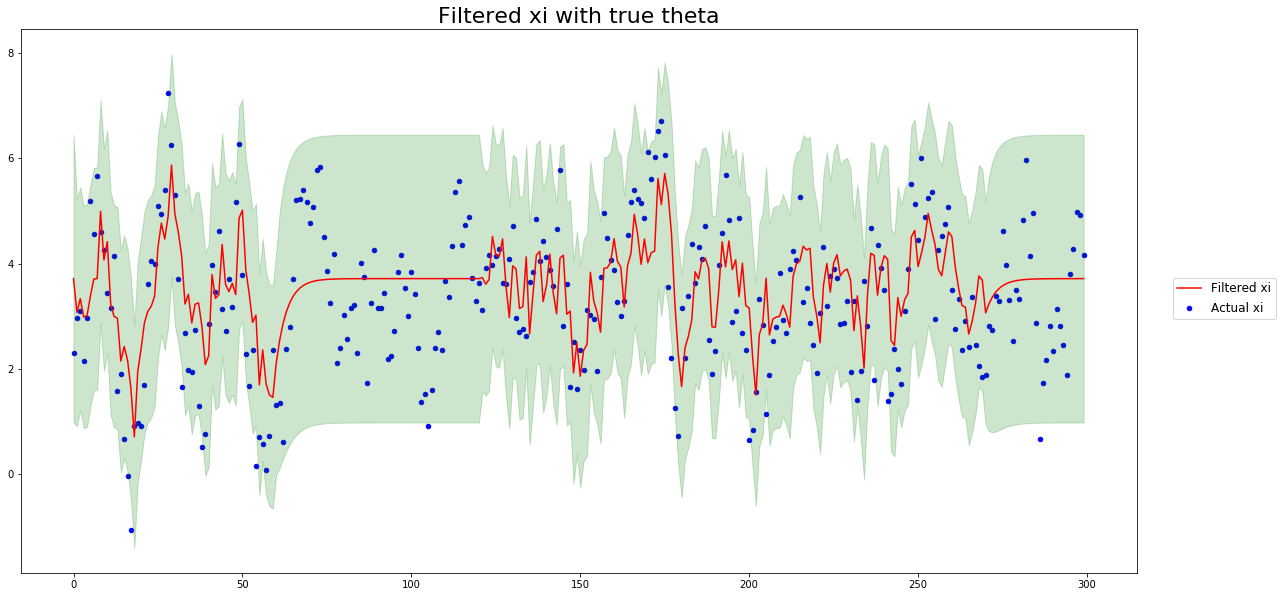

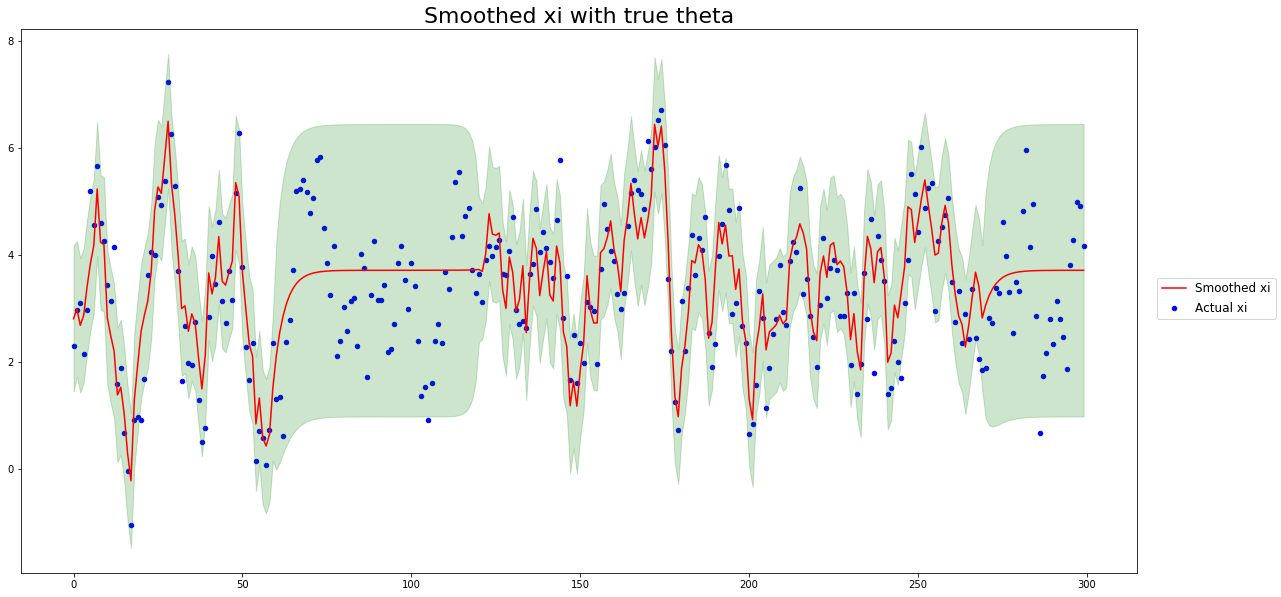

In [9]:
# View filtered states and smoothed states with true
df_true['xi0_f_ub'] = df_true.xi0_filtered + 1.96 * np.sqrt(df_true.P0_filtered)
df_true['xi0_f_lb'] = df_true.xi0_filtered - 1.96 * np.sqrt(df_true.P0_filtered)
df_true['xi0_s_ub'] = df_true.xi0_smoothed + 1.96 * np.sqrt(df_true.P0_smoothed)
df_true['xi0_s_lb'] = df_true.xi0_smoothed - 1.96 * np.sqrt(df_true.P0_smoothed)
ax = plt.figure(figsize=(20, 10))
plt.plot(df_true.index, df_true.xi0_filtered, 'r', label='Filtered xi')
plt.scatter(df_true.index, df_true.xi_0, s=20, c='b', marker='o', label='Actual xi')
plt.fill_between(df_true.index, df_true.xi0_f_ub, df_true.xi0_f_lb, color='g', alpha=0.2)
ax.legend(loc='right', fontsize=12)
plt.title('Filtered xi with true theta', fontsize=22)
plt.show()


ax = plt.figure(figsize=(20, 10))
plt.plot(df_true.index, df_true.xi0_smoothed, 'r', label='Smoothed xi')
plt.scatter(df_true.index, df_true.xi_0, s=20, c='b', marker='o', label='Actual xi')
plt.fill_between(df_true.index, df_true.xi0_s_ub, df_true.xi0_s_lb, color='g', alpha=0.2)
ax.legend(loc='right', fontsize=12)
plt.title('Smoothed xi with true theta', fontsize=22)
plt.show()

In [10]:
# Calculate Statistics
RMSE = {}
RMSE['true'] = np.sqrt((df_true.y_0_filtered - df_true.y_0_vis).var())
RMSE['LLY'] = np.sqrt((df_LLY.y_0_filtered - df_LLY.y_0_vis).var())

M_error = {}
M_error['true'] = (df_true.y_0_filtered - df_true.y_0_vis).mean()
M_error['LLY'] = (df_LLY.y_0_filtered - df_LLY.y_0_vis).mean()

print(RMSE)
print(M_error)

{'true': 1.4112103833451173, 'LLY': 1.403266547381814}
{'true': 0.23142816613509107, 'LLY': -0.03367270699234611}


In [11]:
# Calculate Statistics for offset
df_LLY = df_LLY.iloc[offset_t:].copy()
df_true = df_true.iloc[offset_t:].copy()

RMSE = {}
RMSE['true'] = np.sqrt((df_true.y_0_filtered - df_true.y_0_vis).var())
RMSE['LLY'] = np.sqrt((df_LLY.y_0_filtered - df_LLY.y_0_vis).var())

M_error = {}
M_error['true'] = (df_true.y_0_filtered - df_true.y_0_vis).mean()
M_error['LLY'] = (df_LLY.y_0_filtered - df_LLY.y_0_vis).mean()

print(RMSE)
print(M_error)

{'true': 1.3135905420110572, 'LLY': 1.2979009153882899}
{'true': 0.39044192426357943, 'LLY': -0.05341928758045083}
